# IN4310 - Nore Skulesson Stene - noress - Assignment 1

## Task 1 - Dataset loading

In [1]:
# Imports
import os
import numpy as np
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split
from pathlib import Path

"""
import torch
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
#!pip list --user
"""

print("Numpy version:", np.__version__) # Should be numpy-1.26.4
print("All packages are installed correctly!")

Numpy version: 1.26.4
All packages are installed correctly!


In [2]:
# Set dataset directories
DATASET_ROOT = Path("mandatory1_data")
CLASS_FOLDERS = []
OUTPUT_ROOT = Path("./dataset_splits") 

# Create lists to store file paths and labels
image_paths = []
labels = []
class_names = sorted([directory.name for directory in DATASET_ROOT.iterdir() if directory.is_dir()])  # Get class names

# Task 1a - Splitting Data
# Collect all image file paths and their labels
for label, class_name in enumerate(class_names):
    class_directory_path = DATASET_ROOT / class_name
    files = list(class_directory_path.glob("*.jpg"))
    image_paths.extend(files)
    labels.extend([label] * len(files))

# Convert lists to NumPy arrays
image_paths = np.array(image_paths)
labels = np.array(labels)

print(class_names)
print(image_paths[0])
print(len(image_paths))

for c in class_names:
    print(c)

val_size = 2000  
test_size = 3000  
train_ratio = 1 - ((val_size + test_size) / 17034)  # Remaining percentage for training

# Splitter ut test datasett
train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
    image_paths, labels, test_size=test_size, stratify=labels, random_state=42
)

# Splitter ut val datasett fra train+val
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_val_paths, train_val_labels, test_size=val_size, stratify=train_val_labels, random_state=42
)

# Ny mappefordeling
def move_files(image_paths, labels, split_name):
    split_dir = OUTPUT_ROOT / split_name
    split_dir.mkdir(parents=True, exist_ok=True)

    for class_name in class_names:
        (split_dir / class_name).mkdir(parents=True, exist_ok=True)  # Creating class folders

    for img_path, label in zip(image_paths, labels):
        class_name = class_names[label]
        shutil.copy(img_path, split_dir / class_name / img_path.name)  # Copying files to new location

# Flytter filene til ny splittet mappestruktur
move_files(train_paths, train_labels, "train")
move_files(val_paths, val_labels, "val")
move_files(test_paths, test_labels, "test")

print(f"Data successfully split into Training ({len(train_paths)}), Validation ({len(val_paths)}), and Test ({len(test_paths)}) sets.")

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
mandatory1_data/buildings/13135.jpg
17034
buildings
forest
glacier
mountain
sea
street
Data successfully split into Training (12034), Validation (2000), and Test (3000) sets.


In [3]:
# Task 1b
# Verifying that no files should be in multiple subsets   
def VerifySplits():
    # Putting image file paths in lists
    train_files = {img.name for img in train_paths}
    val_files = {img.name for img in val_paths}
    test_files = {img.name for img in test_paths}

    # Checking for overlapping files using intersection
    train_val_overlap = train_files.intersection(val_files)
    train_test_overlap = train_files.intersection(test_files)
    val_test_overlap = val_files.intersection(test_files)

    # Asserting no overlaps exist
    assert not train_val_overlap, f"Overlap found between train and val: {train_val_overlap}"
    assert not train_test_overlap, f"Overlap found between train and test: {train_test_overlap}"
    assert not val_test_overlap, f"Overlap found between val and test: {val_test_overlap}"

    print("Dataset verfication complete")

VerifySplits()

Dataset verfication complete


In [4]:
# Task 1c
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

print("Torch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)

class ImageDataset(Dataset):
    def __init__(self, dataset_dir, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform

        # Get all image paths and labels
        for class_idx, class_name in enumerate(class_names):
            class_folder = dataset_dir / class_name
            for img_path in class_folder.glob("*.jpg"):  # Adjust if other formats exist
                self.image_paths.append(img_path)
                self.labels.append(class_idx)  # Class index as label

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load image
        image = Image.open(img_path).convert("RGB")

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)

        return image, label


transformTrain = transforms.Compose([
    # Generalization
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Resize all images to 224x224 for consistency
    
    # Tensoring and Normalize
    transforms.ToTensor(),          # Convert image to PyTorch tensor (C, H, W)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for ResNet
])

# Transforming Data without generalization - on val and test set
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 224x224 for consistency
    transforms.ToTensor(),          # Convert image to PyTorch tensor (C, H, W)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for ResNet
])

# Creating Dataloaders - Look into prefetch_factor=2
def get_dataloaders(batch_size=32, shuffle=True):
    train_dataset = ImageDataset(OUTPUT_ROOT / "train", transform=transformTrain)
    val_dataset = ImageDataset(OUTPUT_ROOT / "val", transform=transform)
    test_dataset = ImageDataset(OUTPUT_ROOT / "test", transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=8)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

    return train_loader, val_loader, test_loader


# Testing dataloaders
train_loader, val_loader, test_loader = get_dataloaders()
print(f"DataLoaders created. Train: {len(train_loader.dataset)}, Val: {len(val_loader.dataset)}, Test: {len(test_loader.dataset)}")

# Had folder problems
print("Class names:", class_names)
print("Number of classes:", len(class_names))

Torch version: 2.6.0+cu118
Torchvision version: 0.21.0+cu118
DataLoaders created. Train: 12034, Val: 2000, Test: 3000
Class names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Number of classes: 6


## Task 2 - Building and training the ResNet Architecture

In [5]:
from Precode.ResNet import ResNet

# Debugging issues
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

""" Look into Grad scaler
from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler()  # Automatically scales gradients for stability
for batchImages, labels in train_loader:
    batchImages, labels = batchImages.to(config["device"]), labels.to(config["device"])

    optimizer.zero_grad()

    with autocast():  # Mixed precision context
        outputs = model(batchImages)
        loss = criterion(outputs, labels)

    scaler.scale(loss).backward()  # Scale loss to avoid underflow
    scaler.step(optimizer)
    scaler.update()
"""

config = {
    "device": torch.device("cuda:2" if torch.cuda.is_available() else "cpu"),  # GPU or CPU
    "num_epochs": 20, # Smaller = Less work
    "batch_size": 16, # Smaller = Less memory longer t
    "learning_rate": 0.001, # Smaller = less chance of overfitting -- Could use a lr-scheduler from torch
    "num_classes": 6,
    "img_channels": 3,
    "num_layers": 18,  # ResNet-18
    "num_workers": 2,  # Dataloader workers - Less = slower
    "pin_memory": True,  # Faster and more efficient training
    "momentum": 0.5
}


print("Using device:", config["device"])

# Limit GPU memory to ~2GB
torch.cuda.set_per_process_memory_fraction(0.08, device=config["device"])  # 8% of 24 = 2

# Initializing 
model = ResNet(img_channels=config["img_channels"], num_layers=config["num_layers"], num_classes=config["num_classes"]).to(config["device"])

# Look into saving and only loading the weights in model - Saving memory

# Creating an instance of "torch.optim.SGD" - Maybe test Adam as well
optimizer = torch.optim.SGD(model.parameters(), lr=config["learning_rate"], momentum=config["momentum"])

# Creating loss function - CEL
criterion = torch.nn.CrossEntropyLoss()

# 2.2 - E - Storing for plots
# Lists to track losses and mAP
train_losses = []
val_losses = []
test_losses = []


# Per-class accuracy over epochs (store as list of lists)
val_per_class_acc = []
test_per_class_acc = []


# Epoch training and validating
for epoch in range(1, config["num_epochs"] + 1):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    print(f"\nEpoch {epoch}/{config['num_epochs']}")

    # Training
    for batchImages, labels in train_loader:
        batchImages, labels = batchImages.to(config["device"]), labels.to(config["device"])

        optimizer.zero_grad() # Zeroing gradients
        outputs = model(batchImages) # Forward 
        loss = criterion(outputs, labels) # Calculating loss
        loss.backward() # Backpropagation
        optimizer.step()

        # Metrics
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)  # Track train loss
    print(f"Train Loss: {avg_loss:.4f}, Accuracy: {100 * correct_train / total_train:.2f}%")
    
    # Validation
    model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0
    
    correct_test = 0
    test_loss = 0.0
    total_test = 0

    with torch.no_grad():
        # Storing EpochLoss from valset
        for valImages, valLabels in val_loader:
            valImages, valLabels = valImages.to(config["device"]), valLabels.to(config["device"])

            outputs = model(valImages)
            loss = criterion(outputs, valLabels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += valLabels.size(0)
            correct_val += (predicted == valLabels).sum().item()
        
        # Storing EpochLoss from Testset
        for testImages, testLabels in test_loader:
            testImages, testLabels = testImages.to(config["device"]), testLabels.to(config["device"])
            
            outputs = model(testImages)
            loss = criterion(outputs, testLabels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_test += testLabels.size(0)
            correct_test += (predicted == testLabels).sum().item()
    
    # Calculating accuracy val-set
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    
    # Calculating accuracy val-set
    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = 100 * correct_test / total_test
    #print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    
    # Store losses for plots
    val_losses.append(avg_val_loss)  
    test_losses.append(avg_test_loss)  


print("\nTraining completed!")

Using device: cuda:2

Epoch 1/20
Train Loss: 1.2369, Accuracy: 51.01%
Validation Loss: 1.1471, Validation Accuracy: 55.00%

Epoch 2/20
Train Loss: 0.9609, Accuracy: 63.47%
Validation Loss: 0.7441, Validation Accuracy: 71.90%

Epoch 3/20
Train Loss: 0.8397, Accuracy: 68.43%
Validation Loss: 0.7652, Validation Accuracy: 69.50%

Epoch 4/20
Train Loss: 0.7759, Accuracy: 70.37%
Validation Loss: 0.7557, Validation Accuracy: 72.60%

Epoch 5/20
Train Loss: 0.7391, Accuracy: 72.31%
Validation Loss: 0.6260, Validation Accuracy: 76.40%

Epoch 6/20
Train Loss: 0.6966, Accuracy: 74.17%
Validation Loss: 0.5321, Validation Accuracy: 81.00%

Epoch 7/20
Train Loss: 0.6718, Accuracy: 75.18%
Validation Loss: 1.0090, Validation Accuracy: 64.45%

Epoch 8/20
Train Loss: 0.6722, Accuracy: 75.43%
Validation Loss: 0.4992, Validation Accuracy: 82.65%

Epoch 9/20
Train Loss: 0.6255, Accuracy: 76.93%
Validation Loss: 1.1273, Validation Accuracy: 69.30%

Epoch 10/20
Train Loss: 0.6289, Accuracy: 76.66%
Validation 

Validation Metrics:

Overall Accuracy: 0.8055
Mean Average Precision (mAP): 0.8919

Class 0 - Accuracy: 0.8770, AP: 0.8679
Class 1 - Accuracy: 0.9379, AP: 0.9848
Class 2 - Accuracy: 0.7550, AP: 0.8880
Class 3 - Accuracy: 0.6527, AP: 0.8251
Class 4 - Accuracy: 0.8838, AP: 0.8760
Class 5 - Accuracy: 0.7515, AP: 0.9098

Test Metrics:

Overall Accuracy: 0.7967
Mean Average Precision (mAP): 0.8870

Class 0 - Accuracy: 0.8769, AP: 0.8606
Class 1 - Accuracy: 0.9296, AP: 0.9818
Class 2 - Accuracy: 0.7889, AP: 0.8815
Class 3 - Accuracy: 0.5757, AP: 0.7858
Class 4 - Accuracy: 0.9041, AP: 0.8989
Class 5 - Accuracy: 0.7343, AP: 0.9131



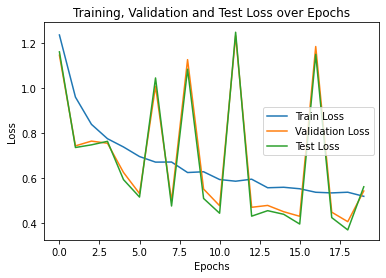

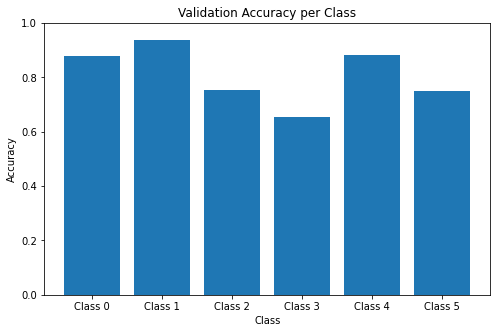

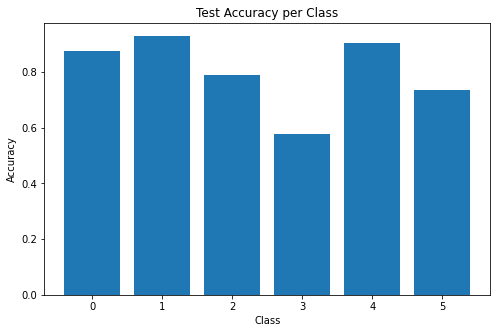

In [6]:
# Task 2.2C
# Evaluating Accuracy and AP per class on val set and test set
# Acc = TP+TN / n
# AP = ...
# mAP = mean AP
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt

# Evaluate model function - 2E
def evaluate_model(model, dataloader, device, num_classes=6):
    model.eval()
    all_outputs = []
    all_labels = []
    
    # Adding images in all_outputs and all_labels 
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            all_outputs.append(outputs.cpu()) # .cpu() because of using scikit libs
            all_labels.append(labels.cpu())
    
    
    all_outputs = torch.cat(all_outputs, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    # Finding out accuracy
    _, predicted = torch.max(all_outputs, 1)    
    N = all_labels.size(0)
    TNAndTP = (predicted == all_labels).sum().item()   
    A = TNAndTP / N
    
    # Per-class accuracy
    per_class_correct = torch.zeros(num_classes)
    per_class_N = torch.zeros(num_classes)
    
    for i in range(num_classes):
        class_mask = (all_labels == i)
        per_class_correct[i] = (predicted[class_mask] == i).sum().item()
        per_class_N[i] = class_mask.sum().item()
        
    per_class_A = per_class_correct / per_class_N
    
    # Average Precision (AP) per class
    probabilities = torch.softmax(all_outputs, dim=1).numpy()
    true_labels = all_labels.numpy()
    
    ap_per_class = []
    for i in range(num_classes):
        binary_labels = (true_labels == i).astype(int)
        class_probs = probabilities[:, i]
        ap = average_precision_score(binary_labels, class_probs)
        ap_per_class.append(ap)

    mAP = np.mean(ap_per_class)

    # Print results
    print(f"\nOverall Accuracy: {A:.4f}")
    print(f"Mean Average Precision (mAP): {mAP:.4f}\n")

    for i in range(num_classes):
        print(f"Class {i} - Accuracy: {per_class_A[i]:.4f}, AP: {ap_per_class[i]:.4f}")
        
    
    

    return A, per_class_A, ap_per_class, mAP


# 2.2 E - Plots
print("Validation Metrics:")
val_accuracy, val_class_acc, val_ap, val_mAPs = evaluate_model(model, val_loader, config["device"], num_classes=config["num_classes"])

print("\nTest Metrics:")
test_accuracy, test_class_acc, test_ap, test_mAPs = evaluate_model(model, test_loader, config["device"], num_classes=config["num_classes"])
print()

# Plotting etc
def plot(train_losses, val_losses, test_losses, val_class_acc, test_class_acc):
    # Loss Graph
    plt.figure()
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training, Validation and Test Loss over Epochs')
    plt.legend()
    plt.show()

    # Per-class accuracy - Validation
    plt.figure(figsize=(8, 5))
    plt.bar(range(config["num_classes"]), val_class_acc)
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy per Class')
    plt.xticks(range(config["num_classes"]), [f'Class {i}' for i in range(config["num_classes"])])  # Optional custom labels
    plt.ylim(0, 1)  # Accuracy range 0 to 1
    plt.show()

    # Per-class accuracy - Test
    plt.figure(figsize=(8, 5))
    plt.bar(range(config["num_classes"]), test_class_acc)
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.title('Test Accuracy per Class')
    plt.xticks(range(config["num_classes"]))  # Ensure correct class labels
    plt.show()

plot(train_losses, val_losses, test_losses, val_class_acc, test_class_acc)
"""
Comments on plots
When trying to figure out why the losses in validation and test were oscillating I thought of a bunch of things:
- In retrospect after seeing the results from using a pretrained resnet this was probably the main issue--lack of pretrained features
- I also thought i had too high momentum;it was okay
- Maybe too high lr;but was okay
- Batch size maybe too low;would like it to be higher but also wanted to limit the VRAM
- Also could implement some more data augmentation techniques
"""

In [7]:
# 2.2 - F - Importing PreTrained ResNet18
import torchvision.models as models

#initializing a resnet18 model with pretrained weights
model = models.resnet18(pretrained=True) # Might have to swap pretrained with weights

# Reshaping final fully connected layer to match 6 classes
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, config["num_classes"])  # 6 output classes

# Move model to GPU or CPU
model = model.to(config["device"])

#print(model)  # Print architecture to verify

# Optimizer and loss
optimizer = torch.optim.SGD(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=config["learning_rate"],
    momentum=config["momentum"],
    weight_decay=1e-4)


# 2.2 - E - Storing for plots
# Lists to track losses and mAP
pre_train_losses = []
pre_val_losses = []
pre_test_losses = []

# Per-class accuracy over epochs
pre_val_per_class_acc = []
pre_test_per_class_acc = []


# Epoch training and validating
for epoch in range(1, config["num_epochs"] + 1):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    print(f"\nEpoch {epoch}/{config['num_epochs']}")

    # Training
    for batchImages, labels in train_loader:
        batchImages, labels = batchImages.to(config["device"]), labels.to(config["device"])

        optimizer.zero_grad() # Zeroing gradients
        outputs = model(batchImages) # Forward 
        loss = criterion(outputs, labels) # Calculating loss
        loss.backward() # Backpropagation
        optimizer.step()

        # Metrics
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    pre_train_losses.append(avg_loss)  # Track train loss
    print(f"Train Loss: {avg_loss:.4f}, Accuracy: {100 * correct_train / total_train:.2f}%")
    
    # Validation
    model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0
    
    correct_test = 0
    test_loss = 0.0
    total_test = 0

    with torch.no_grad():
        # Storing EpochLoss from valset
        for valImages, valLabels in val_loader:
            valImages, valLabels = valImages.to(config["device"]), valLabels.to(config["device"])

            outputs = model(valImages)
            loss = criterion(outputs, valLabels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += valLabels.size(0)
            correct_val += (predicted == valLabels).sum().item()
        
        # Storing EpochLoss from Testset
        for testImages, testLabels in test_loader:
            testImages, testLabels = testImages.to(config["device"]), testLabels.to(config["device"])
            
            outputs = model(testImages)
            loss = criterion(outputs, testLabels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_test += testLabels.size(0)
            correct_test += (predicted == testLabels).sum().item()
    
    # Calculating accuracy val-set
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    
    # Calculating accuracy val-set
    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = 100 * correct_test / total_test
    #print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    
    # Store losses for plots
    pre_val_losses.append(avg_val_loss)  
    pre_test_losses.append(avg_test_loss)  


print("\nTraining completed!")


Epoch 1/20


/itf-fi-ml/home/noress/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/itf-fi-ml/home/noress/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train Loss: 0.7862, Accuracy: 74.87%
Validation Loss: 0.3237, Validation Accuracy: 89.75%

Epoch 2/20
Train Loss: 0.4408, Accuracy: 84.80%
Validation Loss: 0.2853, Validation Accuracy: 89.80%

Epoch 3/20
Train Loss: 0.4061, Accuracy: 85.59%
Validation Loss: 0.2625, Validation Accuracy: 90.55%

Epoch 4/20
Train Loss: 0.3660, Accuracy: 86.79%
Validation Loss: 0.2542, Validation Accuracy: 91.10%

Epoch 5/20
Train Loss: 0.3543, Accuracy: 87.05%
Validation Loss: 0.2431, Validation Accuracy: 91.35%

Epoch 6/20
Train Loss: 0.3392, Accuracy: 88.04%
Validation Loss: 0.2390, Validation Accuracy: 91.65%

Epoch 7/20
Train Loss: 0.3306, Accuracy: 87.83%
Validation Loss: 0.2289, Validation Accuracy: 92.15%

Epoch 8/20
Train Loss: 0.3173, Accuracy: 88.85%
Validation Loss: 0.2290, Validation Accuracy: 92.00%

Epoch 9/20
Train Loss: 0.3101, Accuracy: 88.52%
Validation Loss: 0.2295, Validation Accuracy: 92.15%

Epoch 10/20
Train Loss: 0.3062, Accuracy: 88.89%
Validation Loss: 0.2233, Validation Accuracy

Validation Metrics:

Overall Accuracy: 0.9240
Mean Average Precision (mAP): 0.9715

Class 0 - Accuracy: 0.9353, AP: 0.9812
Class 1 - Accuracy: 0.9783, AP: 0.9953
Class 2 - Accuracy: 0.8588, AP: 0.9502
Class 3 - Accuracy: 0.9048, AP: 0.9330
Class 4 - Accuracy: 0.9541, AP: 0.9892
Class 5 - Accuracy: 0.9201, AP: 0.9805

Test Metrics:

Overall Accuracy: 0.9340
Mean Average Precision (mAP): 0.9760

Class 0 - Accuracy: 0.9568, AP: 0.9812
Class 1 - Accuracy: 0.9896, AP: 0.9985
Class 2 - Accuracy: 0.8733, AP: 0.9528
Class 3 - Accuracy: 0.8935, AP: 0.9456
Class 4 - Accuracy: 0.9837, AP: 0.9962
Class 5 - Accuracy: 0.9173, AP: 0.9818



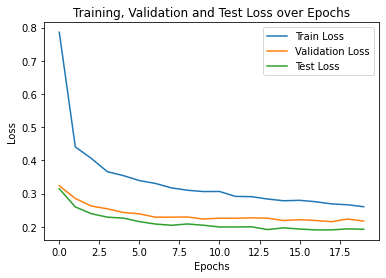

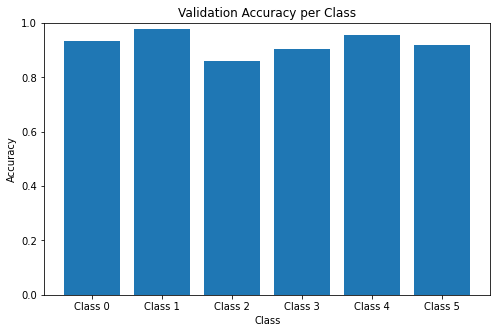

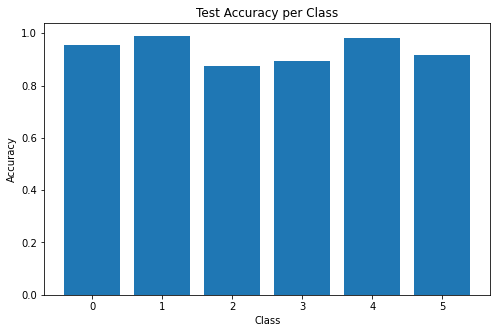

In [8]:
# 2.2 F - Pretrained Plots
print("Validation Metrics:")
pre_val_accuracy, pre_val_class_acc, pre_val_ap, pre_val_mAPs = evaluate_model(model, val_loader, config["device"], num_classes=config["num_classes"])

print("\nTest Metrics:")
pre_test_accuracy, pre_test_class_acc, pre_test_ap, pre_test_mAPs = evaluate_model(model, test_loader, config["device"], num_classes=config["num_classes"])
print()

plot(pre_train_losses, pre_val_losses, pre_test_losses, pre_val_class_acc, pre_test_class_acc)

"""
Observation - Looks much better than the model trained from "scratch".
"""

## Task 3 - Feature Map Statistics

Registered hooks for layers: ['layer1', 'layer2', 'layer3', 'layer4']


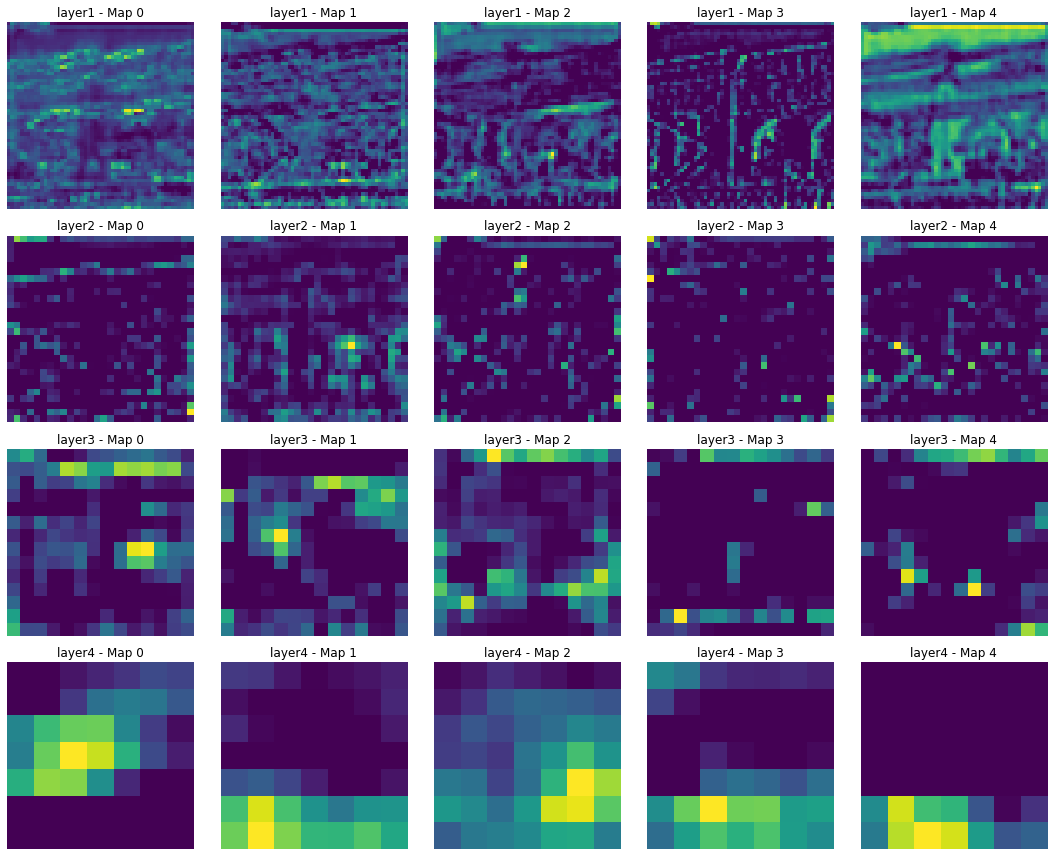

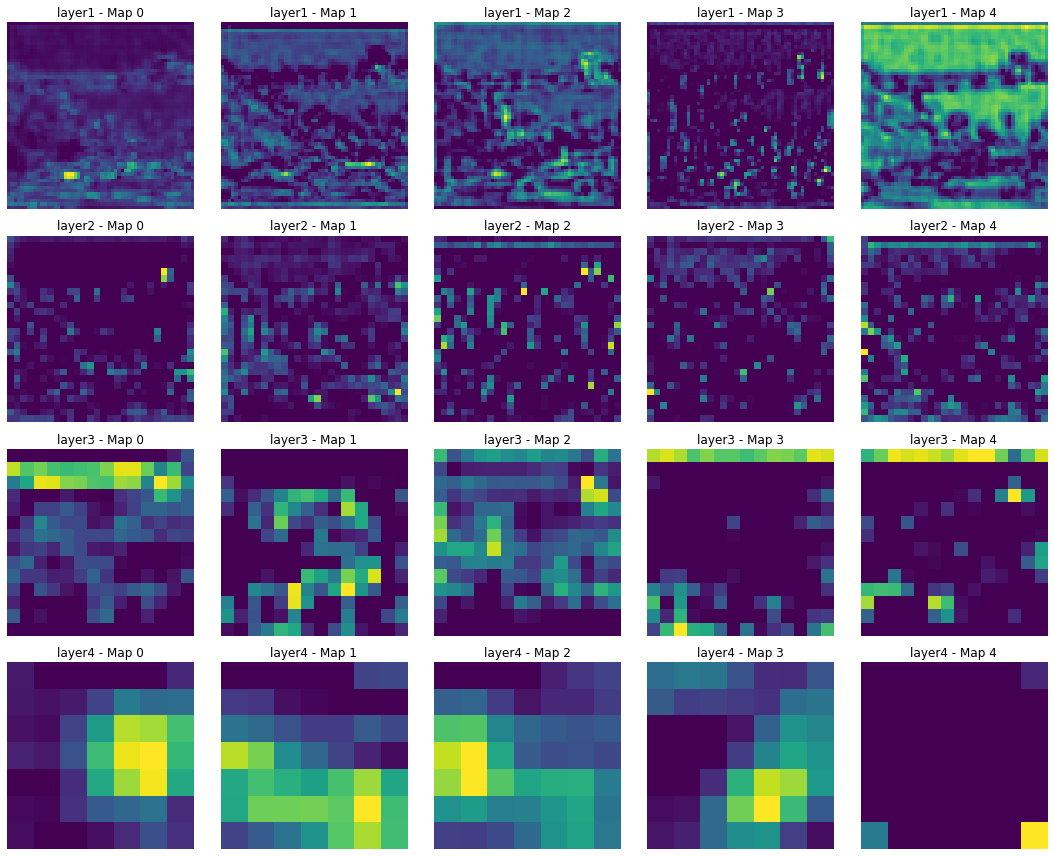

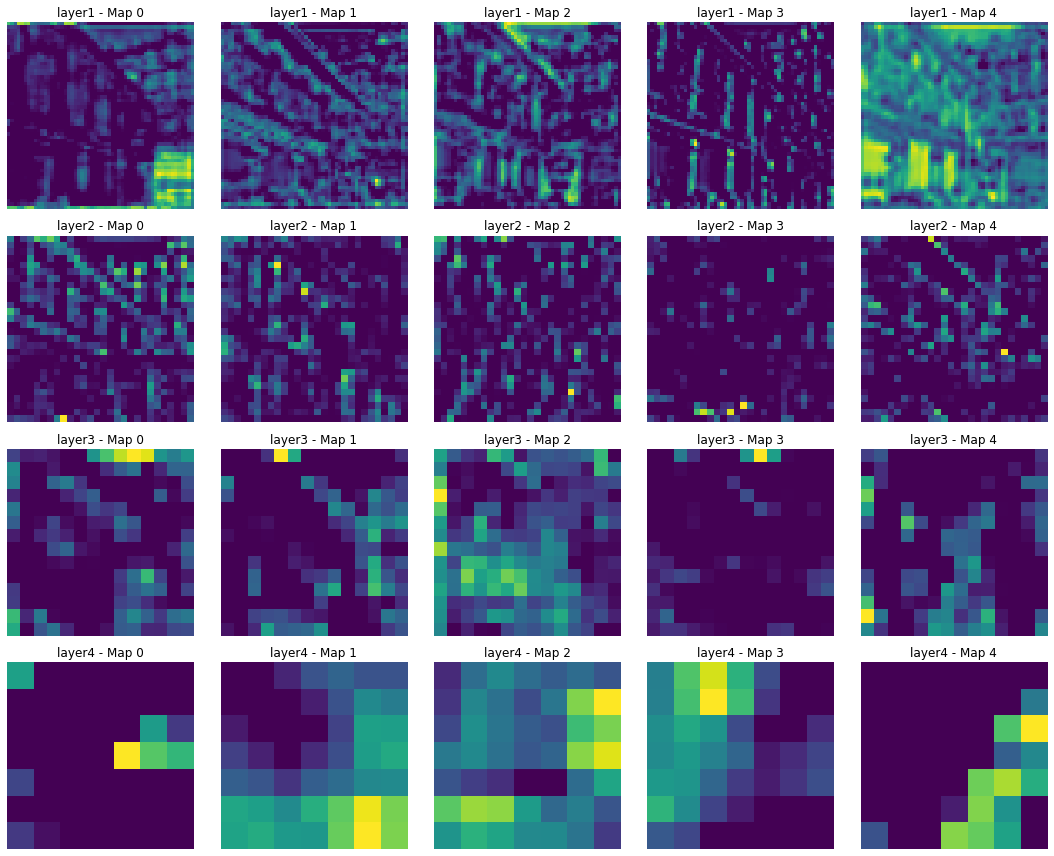

Feature maps saved successfully!


In [9]:
# Part A
layer_names = ['layer1', 'layer2', 'layer3', 'layer4']
feature_maps = {}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) 
model.eval()  

# Part B
def hook_fn(name):
    def hook(module, input, output):
        feature_maps[name] = output.detach().cpu()  # Store output without gradients
    return hook

# Register hooks
hooks = []
for name, module in model.named_modules():
    if name in layer_names:
        hooks.append(module.register_forward_hook(hook_fn(name)))  # Correct hook

print(f"Registered hooks for layers: {layer_names}")

# Part C
# Create output directory for feature maps
output_dir = "featureMaps_output"
os.makedirs(output_dir, exist_ok=True)

# Load first batch of images
data_iter = iter(val_loader) 
images, _ = next(data_iter)
images = images[:3]  # Take first 3 images
images = images.to(device)

# Forward pass and save feature maps 
for idx, img in enumerate(images):
    img = img.unsqueeze(0)  # Adding batch dimension

    feature_maps.clear()  # Clearing stored maps

    _ = model(img)  # Forward pass to trigger hooks

    # Create folder for this image
    img_folder = os.path.join(output_dir, f"image_{idx}")
    os.makedirs(img_folder, exist_ok=True)
    
    fig, axes = plt.subplots(len(feature_maps), 5, figsize=(15, len(feature_maps) * 3))

    # Save feature maps
    for row, (layer_name, fmap) in enumerate(feature_maps.items()):
        fmap = fmap.squeeze(0)  # Remove batch dimension

        # Save first 5 feature maps (channels)
        for i in range(min(5, fmap.shape[0])): 
            ax = axes[row, i] if len(feature_maps) > 1 else axes[i]  # Handle single row case
            ax.imshow(fmap[i], cmap='viridis')
            ax.axis('off')
            ax.set_title(f"{layer_name} - Map {i}")

            # Save each feature map
            plt.imsave(os.path.join(img_folder, f"{layer_name}_map_{i}.png"), fmap[i], cmap='viridis')
            
    plt.tight_layout()
    plt.show()

print("Feature maps saved successfully!")

"""
Observations:
The different layers go deeper and deeper in the pictures-recognizing different things.
The different Maps are the different filters/features that ResNet18 has. Total of 64 in layer 1.
"""